Report/Slide: https://drive.google.com/file/d/1JJBhgtao05zUQPRxRZdnNtsQNLtkA_K-/view?usp=sharing

# Crawl Scratch skin

In [ ]:
!pip install bing-image-downloader -q

In [ ]:
from bing_image_downloader import downloader

key_words = ['', 'adults', 'old people', 'baby', 'by animal', 'by cat']
for key in key_words:
    downloader.download(f'scratch skin {key}', limit=1000)

# **Import libs**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets, transforms
import torchvision
import torch.nn as nn
from torch.nn.init import kaiming_normal_

from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

In [ ]:
# https://drive.google.com/file/d/1M7rj0DDxcc6_VgX_DqRe3DmNAV-5AHGr/view?usp=drive_link
!gdown --id 1M7rj0DDxcc6_VgX_DqRe3DmNAV-5AHGr

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1M7rj0DDxcc6_VgX_DqRe3DmNAV-5AHGr
From (redirected): https://drive.google.com/uc?id=1M7rj0DDxcc6_VgX_DqRe3DmNAV-5AHGr&confirm=t&uuid=34a49b5b-f16a-4a7b-ac5e-d63004f66c66
To: /content/AHS.zip
100% 367M/367M [00:05<00:00, 63.8MB/s]


In [ ]:
!unzip AHS.zip > /dev/null

In [ ]:
root_dir = '/content/AHS'
raw_dataset = {}
categories = ['wound', 'humidity', 'redness', 'scratches']

def train_val_test(root_dir):
    list_images_path = []
    list_labels = []

    for sub_dir in os.listdir(root_dir):
        path_sub_dir = os.path.join(root_dir, sub_dir)
        for image_name in os.listdir(path_sub_dir):
            image_path = os.path.join(path_sub_dir, image_name)
            list_images_path.append(image_path)
            list_labels.append(sub_dir)

    X_train, X_val, y_train, y_val = train_test_split(list_images_path, list_labels, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    return {'train': {'images': X_train, 'labels': y_train},
            'val': {'images': X_val, 'labels': y_val},
            'test': {'images': X_test, 'labels': y_test}}

for category in categories:
    raw_dataset[category] = train_val_test(os.path.join(root_dir, category))
    print(f'{category}: {raw_dataset[category].keys()}')

wound: dict_keys(['train', 'val', 'test'])
humidity: dict_keys(['train', 'val', 'test'])
redness: dict_keys(['train', 'val', 'test'])
scratches: dict_keys(['train', 'val', 'test'])


In [ ]:
len(raw_dataset['humidity']['train']['images']), len(raw_dataset['humidity']['train']['labels']),

(2521, 2521)

In [ ]:
raw_dataset['humidity']['train']['images'][0]

'/content/AHS/humidity/dry/dry_df6b42013b85662caba1_jpg.rf.b3e4cbf6ee1cbb2ce1df0487b3fbd1ef.jpg'

In [ ]:
class ASHDataset(Dataset):
    def __init__(self, list_images_path, list_labels, one_hot_label, transform=None):
        self.category = list_images_path[0].split('/')[3].lower()
        self.one_hot_label = one_hot_label[self.category]
        self.list_images_path = list_images_path
        self.list_labels = list_labels
        self.transform = transform

    def __len__(self):
        return len(self.list_images_path)

    def __getitem__(self, idx):
        image = cv2.imread(self.list_images_path[idx])
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = np.array(self.one_hot_label[self.list_labels[idx]])

        if self.transform:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)
        sample = (image, label)

        return sample

In [ ]:
import albumentations

def get_transforms(image_size=224):
    transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        albumentations.Perspective(p=0.5, scale=(0.05, 0.40), pad_mode=0, mask_pad_val=0),

        albumentations.Blur(p=0.5, blur_limit=(3, 7)),
        albumentations.PixelDropout(p=0.5, dropout_prob=0.05, per_channel=1),

        albumentations.Normalize(),

    ])

    transforms_val = albumentations.Compose([
        albumentations.Normalize(),
    ])

    return transforms_train, transforms_val

In [ ]:
train_transforms, test_transforms = get_transforms(image_size=224)

In [ ]:
# index = 45
# plt.imshow(dataset['wound']['train'][index][0].transpose(1, 2, 0))
# dataset['wound']['train'][index][1]

In [ ]:
root_dir = '/content/AHS'
train_batchsize = 64
test_batchsize = 32

one_hot_label = {'wound': {'normal': 2, 'slightly': 1, 'severe': 0},
                 'humidity': {'normal': 2, 'dry': 1, 'oily': 0},
                 'redness': {'yes': 1, 'no': 0},
                 'scratches': {'yes': 1, 'no': 0}}

dataset = {}
for category in list(one_hot_label.keys()):
    raw = raw_dataset[category]

    train_dataset = ASHDataset(raw['train']['images'], raw['train']['labels'], one_hot_label, transform=train_transforms)
    val_dataset = ASHDataset(raw['val']['images'], raw['val']['labels'], one_hot_label, transform=test_transforms)
    test_dataset = ASHDataset(raw['test']['images'], raw['test']['labels'], one_hot_label, transform=test_transforms)

    # dataset[category] = {'train': train_dataset,
    #                      'valid': val_dataset,
    #                      'test': test_dataset,}

    train_loader = DataLoader(train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=test_batchsize, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=test_batchsize, shuffle=False, num_workers=2)

    dataset[category] = {'train_loader': train_loader,
                         'val_loader': val_loader,
                         'test_loader': test_loader}

    print('-'*55)
    print(' '*20, f'{category}')
    print(f'Train: {len(train_dataset)} samples \t|\t {len(train_loader)} batches')
    print(f'Valid: {len(val_dataset)} samples \t|\t {len(val_loader)} batches')
    print(f'Test: {len(test_dataset)} samples \t|\t {len(test_loader)} batches')

-------------------------------------------------------
                     wound
Train: 2069 samples 	|	 33 batches
Valid: 259 samples 	|	 9 batches
Test: 259 samples 	|	 9 batches
-------------------------------------------------------
                     humidity
Train: 2521 samples 	|	 40 batches
Valid: 315 samples 	|	 10 batches
Test: 316 samples 	|	 10 batches
-------------------------------------------------------
                     redness
Train: 1180 samples 	|	 19 batches
Valid: 148 samples 	|	 5 batches
Test: 148 samples 	|	 5 batches
-------------------------------------------------------
                     scratches
Train: 1143 samples 	|	 18 batches
Valid: 143 samples 	|	 5 batches
Test: 143 samples 	|	 5 batches


In [ ]:
dataset

{'wound': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7995441f3490>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x7995441f33d0>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7995441f1720>},
 'humidity': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7995686801f0>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x799568680be0>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x799568683520>},
 'redness': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x799503d942b0>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x799503d94310>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x799503d94400>},
 'scratches': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x799503d94b20>,
  'val_loader': <torch.utils.data.dataloader.DataLoader at 0x799503d94b80>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x799503d94c70>}}

In [ ]:
sample = next(iter(dataset['wound']['train_loader']))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
sample[0]

tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  0.0398,  0.0398,  0.0227],
          [-2.1179, -2.1179, -2.1179,  ..., -0.0116,  0.0056,  0.0056],
          [-2.1179, -2.1179, -2.1179,  ..., -0.1828, -0.0972, -0.0801],
          ...,
          [ 1.6667,  1.6667,  1.6667,  ..., -2.1179, -2.1179, -2.1179],
          [ 1.6667,  1.6667,  1.6667,  ..., -2.1179, -2.1179, -2.1179],
          [ 1.6667,  1.6667, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357,  0.2402,  0.2402],
          [-2.0357, -2.0357, -2.0357,  ...,  0.1877,  0.2227,  0.2227],
          [-2.0357, -2.0357, -2.0357,  ...,  0.0301,  0.1176,  0.1352],
          ...,
          [ 1.8158,  1.8158,  1.8158,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.8158,  1.8158,  1.8158,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.8158,  1.8158,  1.8158,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.8448, -1.8044,  0.8274],
          [-1.8044, -1.8044, -

# **Model**

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
!pip install torchinfo -q

In [ ]:
from torchinfo import summary

backbone = nn.Sequential(*list(resnet18.children())[:-1])
summary(backbone, input_size=(2, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [2, 512, 1, 1]            --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [2, 64, 56, 56]           --
│

In [ ]:
# for param in backbone.parameters():
#     param.requires_grad_(False)

In [ ]:
class AHS_Model(nn.Module):
    def __init__(self, backbone, droprate = 0.05, mode = 'infer'):
        super().__init__()
        self.mode = mode
        self.feature_extractor = backbone

        self.flatten = nn.Flatten()

        self.humidity_head = self.create_head(linear_dim=[512, 64, 3])
        self.redness_head = self.create_head(linear_dim=[512, 64, 2])
        self.scratch_head = self.create_head(linear_dim=[512, 64, 2])
        self.wound_head = self.create_head(linear_dim=[512, 64, 3])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.flatten(features)

        if self.mode == 'infer':
            return {'humidity': self.humidity_head(features),
                    'redness': self.redness_head(features),
                    'scratch': self.scratch_head(features),
                    'wound': self.wound_head(features)}

        elif self.mode == 'humidity':
            return  self.humidity_head(features)
        elif self.mode == 'redness':
            return  self.redness_head(features)
        elif self.mode == 'scratch':
            return  self.scratch_head(features)
        elif self.mode == 'wound':
            return  self.wound_head(features)
        else:
            return  'Uknown MODE !!!'

    def create_head(self, linear_dim=[512*7*7, 64, 2], droprate=0.05, ReLU=True, use_bn=False):
        layers = []
        for i in range(len(linear_dim) - 1):
            in_features, out_features = linear_dim[i], linear_dim[i + 1]
            linear_layer = nn.Linear(in_features, out_features)

            kaiming_normal_(linear_layer.weight, mode='fan_in', nonlinearity='relu')

            layers.append(linear_layer)

            if ReLU and i < len(linear_dim) - 2:
                layers.append(nn.ReLU(inplace=True))
            if use_bn and i < len(linear_dim) - 2:
                layers.append(nn.BatchNorm1d(out_features))
            if droprate > 0 and i < len(linear_dim) - 2:
                layers.append(nn.Dropout(p=droprate))

        return nn.Sequential(*layers)

In [ ]:
from torchinfo import summary

model = AHS_Model(backbone)
summary(model, input_size=(2, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
AHS_Model                                     [2, 3]                    --
├─Sequential: 1-1                             [2, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [2, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [2, 64, 112, 112]         128
│    └─ReLU: 2-3                              [2, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [2, 64, 56, 56]           --
│    └─Sequential: 2-5                        [2, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [2, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [2, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [2, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [2, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [2, 128, 28, 28]          295,42

In [ ]:
import torch.optim as optim

x1 = torch.Tensor([[1.0, 1.0],
                  [1.0, 1.0]])

x2 = torch.Tensor([[1.0, 1.0],
                   [1.0, 1.0]])

x1 = x1.requires_grad_(True)
x2 = x2.requires_grad_(True)

y = x1.sum()
z = y*y

optimizer = optim.SGD([x1, x2], lr = 0.1)
optimizer.zero_grad()
z.backward()
optimizer.step()

In [ ]:
print(x1)
print(x1.grad)

tensor([[0.2000, 0.2000],
        [0.2000, 0.2000]], requires_grad=True)
tensor([[8., 8.],
        [8., 8.]])


In [ ]:
print(x2)
print(x2.grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


# **Utils**

In [ ]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

In [ ]:
'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

In [ ]:
'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
'''
    Saves the model state dictionary and optimizer state dictionary to a file.
'''
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

'''
  Loads the model state dictionary and optimizer state dictionary from a file.
'''
def load_checkpoint(model, filename="checkpoint.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, epoch

# **Training**

In [ ]:
model = AHS_Model(backbone).to(device)

## Humidity

In [ ]:
for param in model.redness_head.parameters():
    print(f"Parameter size: {param.size()}")
    print(f"Parameter values:\n {param[:5]}")
    check_1 = param[:5]
    break

Parameter size: torch.Size([64, 512])
Parameter values:
 tensor([[ 0.0908, -0.0160, -0.0019,  ...,  0.0606, -0.0084, -0.0733],
        [-0.0415,  0.0659,  0.1322,  ...,  0.0464, -0.0561,  0.0480],
        [ 0.0140,  0.0392,  0.0780,  ..., -0.0432,  0.0357, -0.0058],
        [ 0.0018,  0.0244, -0.0480,  ...,  0.0791, -0.0424, -0.0478],
        [ 0.0358,  0.0410,  0.0866,  ..., -0.1796, -0.0518, -0.0471]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
model.mode = 'humidity'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.7362974271178245, Valid_loss: 0.6673161387443542, Train_accuracy: 67.55255850852836, Valid_accuracy: 73.01587301587301
Epochs: 1, Train_loss: 0.7056102678179741, Valid_loss: 0.7192860245704651, Train_accuracy: 69.93256644188814, Valid_accuracy: 71.74603174603175
Epochs: 2, Train_loss: 0.6563453689217568, Valid_loss: 0.6977776050567627, Train_accuracy: 70.17056723522411, Valid_accuracy: 77.77777777777779
Epochs: 3, Train_loss: 0.662425085902214, Valid_loss: 0.6487947285175324, Train_accuracy: 72.4315747719159, Valid_accuracy: 76.19047619047619
Epochs: 4, Train_loss: 0.6078866101801396, Valid_loss: 0.5910509288311004, Train_accuracy: 73.46291154303847, Valid_accuracy: 77.77777777777779
Epochs: 5, Train_loss: 0.5984684340655804, Valid_loss: 0.5838716328144073, Train_accuracy: 74.93058310194367, Valid_accuracy: 79.36507936507937
Epochs: 6, Train_loss: 0.5865023791790008, Valid_loss: 0.6173904627561569, Train_accuracy: 78.38159460531536, Valid_accuracy: 78.730158730

<ipython-input-22-9d8ca1ce1d69>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


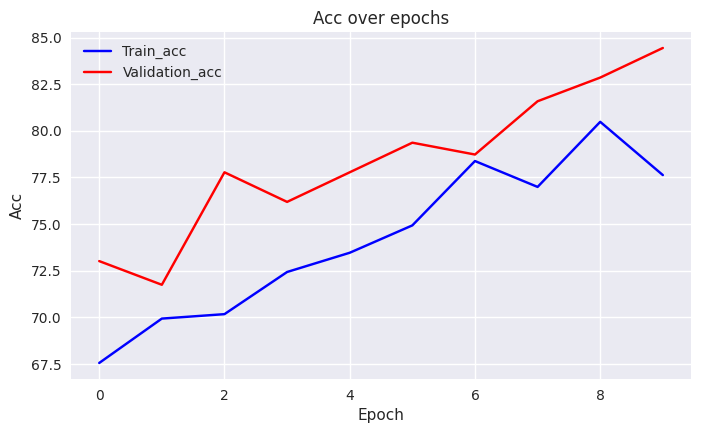

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, dataset['humidity']['train_loader'], dataset['humidity']['val_loader'], 10, device) # 40 epochs

In [ ]:
for param in model.redness_head.parameters():
    print(f"Parameter size: {param.size()}")
    print(f"Parameter values:\n {param[:5]}")
    check_2 = param[:5]
    break

Parameter size: torch.Size([64, 512])
Parameter values:
 tensor([[ 0.0908, -0.0160, -0.0019,  ...,  0.0606, -0.0084, -0.0733],
        [-0.0415,  0.0659,  0.1322,  ...,  0.0464, -0.0561,  0.0480],
        [ 0.0140,  0.0392,  0.0780,  ..., -0.0432,  0.0357, -0.0058],
        [ 0.0018,  0.0244, -0.0480,  ...,  0.0791, -0.0424, -0.0478],
        [ 0.0358,  0.0410,  0.0866,  ..., -0.1796, -0.0518, -0.0471]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
(check_1 - check_2).sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
save_checkpoint(model, optimizer, epoch=40)
!cp '/content/checkpoint.pth' '/content/drive/MyDrive/Internship/AHS/checkpoint.pth'

In [ ]:
for param in model.feature_extractor.parameters():
    param.requires_grad_(False)

for param in model.humidity_head.parameters():
    param.requires_grad_(False)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

98951

## Redness

In [ ]:
model, _ = load_checkpoint(model, filename="checkpoint.pth")

In [ ]:
model.mode = 'redness'
optimizer = torch.optim.Adam(model.redness_head.parameters(), lr=1e-4)
# class_weights = torch.tensor([1, 1274 / 202])
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.5549904609981337, Valid_loss: 0.38311159908771514, Train_accuracy: 83.72881355932203, Valid_accuracy: 88.51351351351352
Epochs: 1, Train_loss: 0.4115970652354391, Valid_loss: 0.2769376695156097, Train_accuracy: 85.67796610169492, Valid_accuracy: 89.86486486486487
Epochs: 2, Train_loss: 0.35240097422348826, Valid_loss: 0.22524214088916777, Train_accuracy: 86.61016949152543, Valid_accuracy: 92.56756756756756
Epochs: 3, Train_loss: 0.30158660678487076, Valid_loss: 0.19835787117481232, Train_accuracy: 89.15254237288136, Valid_accuracy: 92.56756756756756
Epochs: 4, Train_loss: 0.290538805095773, Valid_loss: 0.17818609178066253, Train_accuracy: 88.13559322033898, Valid_accuracy: 92.56756756756756


<ipython-input-22-9d8ca1ce1d69>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


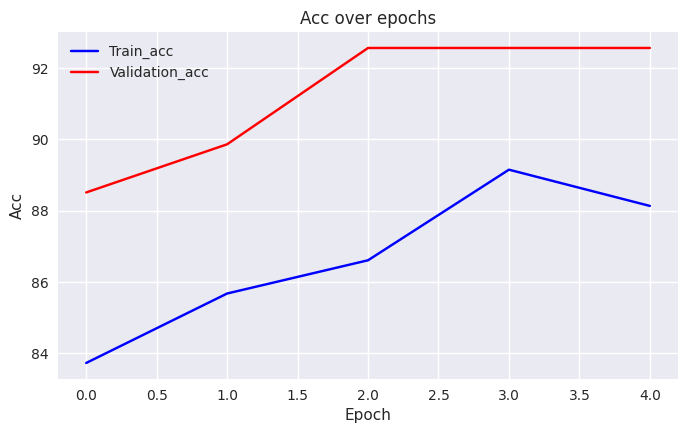

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, dataset['redness']['train_loader'], dataset['redness']['val_loader'], 5, device) # 5 epochs

In [ ]:
for param in model.redness_head.parameters():
    param.requires_grad_(False)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

65989

In [ ]:
save_checkpoint(model, optimizer, epoch=5, filename="checkpoint2.pth")
!cp '/content/checkpoint2.pth' '/content/drive/MyDrive/Internship/AHS/checkpoint2.pth'

## scratch

In [ ]:
model.mode = 'scratch'
optimizer = torch.optim.Adam(model.scratch_head.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.4855861763159434, Valid_loss: 0.24049986340105534, Train_accuracy: 89.41382327209098, Valid_accuracy: 93.7062937062937
Epochs: 1, Train_loss: 0.27350372986661065, Valid_loss: 0.2401105785742402, Train_accuracy: 90.02624671916011, Valid_accuracy: 93.7062937062937
Epochs: 2, Train_loss: 0.22599454265501764, Valid_loss: 0.19784569852054118, Train_accuracy: 91.25109361329834, Valid_accuracy: 93.7062937062937
Epochs: 3, Train_loss: 0.22047550686531597, Valid_loss: 0.18298950493335725, Train_accuracy: 92.6509186351706, Valid_accuracy: 93.7062937062937
Epochs: 4, Train_loss: 0.1981801903910107, Valid_loss: 0.18173093311488628, Train_accuracy: 93.61329833770779, Valid_accuracy: 94.4055944055944


<ipython-input-22-9d8ca1ce1d69>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


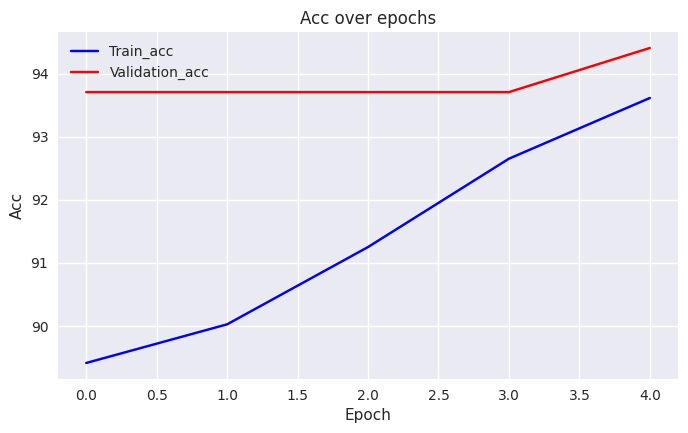

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, dataset['scratches']['train_loader'], dataset['scratches']['val_loader'], 5, device) # 5 epochs

In [ ]:
for param in model.scratch_head.parameters():
    param.requires_grad_(False)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

33027

In [ ]:
save_checkpoint(model, optimizer, epoch=40, filename="checkpoint3.pth")
!cp '/content/checkpoint3.pth' '/content/drive/MyDrive/Internship/AHS/checkpoint3.pth'

## wound

In [ ]:
model.mode = 'wound'
optimizer = torch.optim.Adam(model.wound_head.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 1.384360494035663, Valid_loss: 0.9664100077417161, Train_accuracy: 53.89076848719188, Valid_accuracy: 54.440154440154444
Epochs: 1, Train_loss: 0.7284386203144536, Valid_loss: 0.5956968731350369, Train_accuracy: 74.77042049299179, Valid_accuracy: 79.92277992277992
Epochs: 2, Train_loss: 0.5160020056999091, Valid_loss: 0.4388378957907359, Train_accuracy: 81.19864668922185, Valid_accuracy: 87.64478764478764
Epochs: 3, Train_loss: 0.43649274652654474, Valid_loss: 0.34241092536184525, Train_accuracy: 82.79362010633156, Valid_accuracy: 90.73359073359073
Epochs: 4, Train_loss: 0.3769444182063594, Valid_loss: 0.27434267269240487, Train_accuracy: 86.32189463508941, Valid_accuracy: 91.8918918918919


<ipython-input-22-9d8ca1ce1d69>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


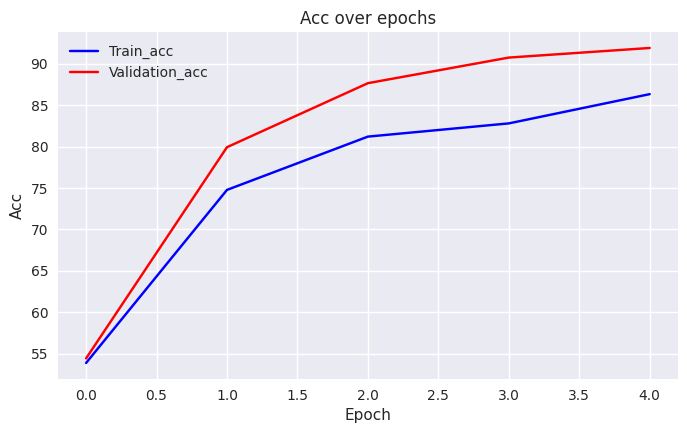

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, dataset['wound']['train_loader'], dataset['wound']['val_loader'], 5, device) # 5 epochs

In [ ]:
for param in model.wound_head.parameters():
    param.requires_grad_(False)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

0

In [ ]:
save_checkpoint(model, optimizer, epoch=40, filename="checkpoint4.pth")
!cp '/content/checkpoint4.pth' '/content/drive/MyDrive/Internship/AHS/checkpoint4.pth'

# Evaluate

In [ ]:
model, _ = load_checkpoint(model, filename="/content/drive/MyDrive/Internship/AHS/model/checkpoint4.pth")

In [ ]:
def evaluate(model, dataset):
    total_accuracy = 0
    for category in ['wound', 'humidity', 'redness']:
        model.mode = category
        head_accuracy = get_accuracy(model, dataset[category]['test_loader'], device)
        total_accuracy += head_accuracy
        print(f'{category} head: {head_accuracy:.2f}%')

    model.mode = 'scratch'
    head_accuracy = get_accuracy(model, dataset['scratches']['test_loader'], device)
    total_accuracy += head_accuracy
    print(f'{model.mode} head: {head_accuracy:.2f}%')

    print('-'*25)
    print(f'Final accuracy: {total_accuracy/4:.2f}%')

In [ ]:
evaluate(model, dataset)

wound head: 91.12%
humidity head: 92.09%
redness head: 91.89%
scratch head: 88.11%
-------------------------
Final accuracy: 90.80%


In [ ]:
from google.colab.patches import cv2_imshow

one_hot_label2 = {'wound': {2: 'normal', 1: 'slightly', 0: 'severe'},
                 'humidity': {0: 'normal', 1: 'dry', 2: 'oily'},
                 'redness': {1: 'yes', 0: 'no'},
                 'scratch': {1: 'yes', 0: 'no'}}

def inference(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    cv2_imshow(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    res = test_transforms(image=image)
    image = res['image'].astype(np.float32)
    image = image.transpose(2, 0, 1)
    image = torch.tensor(image).unsqueeze(0).to(device)

    result = model(image)

    humidity = torch.argmax(torch.tensor(result['humidity'][0].tolist())).item()
    redness = torch.argmax(torch.tensor(result['redness'][0].tolist())).item()
    scratch = torch.argmax(torch.tensor(result['scratch'][0].tolist())).item()
    wound = torch.argmax(torch.tensor(result['wound'][0].tolist())).item()

    print(f'humidity: {one_hot_label2["humidity"][humidity]}')
    print(f'redness: {one_hot_label2["redness"][redness]}')
    print(f'scratch: {one_hot_label2["scratch"][scratch]}')
    print(f'wound: {one_hot_label2["wound"][wound]}')

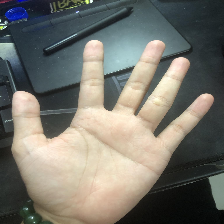

humidity: normal
redness: no
scratch: no
wound: severe


In [ ]:
model.mode = 'infer'
image_path = '/content/drive/MyDrive/Internship/AHS/test image/test1.jpg'
inference(model, image_path)

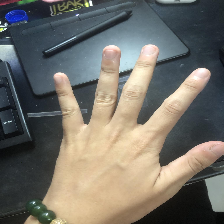

humidity: normal
redness: no
scratch: no
wound: normal


In [ ]:
model.mode = 'infer'
image_path = '/content/drive/MyDrive/Internship/AHS/test image/test2.jpg'
inference(model, image_path)

In [ ]:
model = AHS_Model(backbone).to(device)
model, _ = load_checkpoint(model, filename="/content/drive/MyDrive/Internship/AHS/model/checkpoint4.pth")

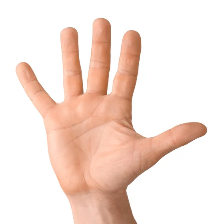

humidity: normal
redness: no
scratch: no
wound: normal


In [ ]:
model.mode = 'infer'
image_path = '/content/drive/MyDrive/Internship/AHS/test image/hehehe.jpg'
inference(model, image_path)

# **Nothing**

In [ ]:
model1_ = {}
for name, param in model.named_parameters():
    model1_[name] = param.data

In [ ]:
model1_['feature_extractor.0.weight']

tensor([[[[-9.4158e-03, -5.1976e-03, -1.0620e-03,  ...,  5.8424e-02,
            1.8928e-02, -1.0695e-02],
          [ 1.1613e-02,  1.0060e-02, -1.0908e-01,  ..., -2.6876e-01,
           -1.2694e-01,  6.3381e-03],
          [-6.0905e-03,  5.9743e-02,  2.9633e-01,  ...,  5.2186e-01,
            2.5839e-01,  6.6572e-02],
          ...,
          [-2.8021e-02,  1.4416e-02,  7.2140e-02,  ..., -3.3162e-01,
           -4.1904e-01, -2.5616e-01],
          [ 2.9785e-02,  4.1243e-02,  6.2655e-02,  ...,  4.1516e-01,
            3.9553e-01,  1.6866e-01],
          [-1.4098e-02, -4.9094e-03, -2.4470e-02,  ..., -1.4915e-01,
           -7.9534e-02, -4.1120e-03]],

         [[-1.0785e-02, -2.6769e-02, -3.3833e-02,  ...,  3.4583e-02,
            2.3920e-03, -2.3645e-02],
          [ 4.6483e-02,  3.3037e-02, -1.0427e-01,  ..., -3.1107e-01,
           -1.5895e-01,  1.5337e-03],
          [-1.8652e-03,  9.7538e-02,  4.0220e-01,  ...,  7.0957e-01,
            3.7069e-01,  1.2711e-01],
          ...,
     

In [ ]:
list(model1_.keys())

['feature_extractor.0.weight',
 'feature_extractor.1.weight',
 'feature_extractor.1.bias',
 'feature_extractor.4.0.conv1.weight',
 'feature_extractor.4.0.bn1.weight',
 'feature_extractor.4.0.bn1.bias',
 'feature_extractor.4.0.conv2.weight',
 'feature_extractor.4.0.bn2.weight',
 'feature_extractor.4.0.bn2.bias',
 'feature_extractor.4.1.conv1.weight',
 'feature_extractor.4.1.bn1.weight',
 'feature_extractor.4.1.bn1.bias',
 'feature_extractor.4.1.conv2.weight',
 'feature_extractor.4.1.bn2.weight',
 'feature_extractor.4.1.bn2.bias',
 'feature_extractor.5.0.conv1.weight',
 'feature_extractor.5.0.bn1.weight',
 'feature_extractor.5.0.bn1.bias',
 'feature_extractor.5.0.conv2.weight',
 'feature_extractor.5.0.bn2.weight',
 'feature_extractor.5.0.bn2.bias',
 'feature_extractor.5.0.downsample.0.weight',
 'feature_extractor.5.0.downsample.1.weight',
 'feature_extractor.5.0.downsample.1.bias',
 'feature_extractor.5.1.conv1.weight',
 'feature_extractor.5.1.bn1.weight',
 'feature_extractor.5.1.bn1.bia

In [ ]:
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
for param in model.humidity_head.parameters():
    param.requires_grad_(True)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

33027

In [ ]:
model.mode = 'humidity'
optimizer = torch.optim.Adam(model.humidity_head.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.5312705941498279, Valid_loss: 0.25551301091909406, Train_accuracy: 78.73859579531933, Valid_accuracy: 91.42857142857143
Epochs: 1, Train_loss: 0.5334414027631282, Valid_loss: 0.24979815483093262, Train_accuracy: 79.41293137643792, Valid_accuracy: 90.47619047619048
Epochs: 2, Train_loss: 0.5307335533201695, Valid_loss: 0.254336229711771, Train_accuracy: 79.05593018643395, Valid_accuracy: 91.74603174603175
Epochs: 3, Train_loss: 0.5191239699721336, Valid_loss: 0.25159312784671783, Train_accuracy: 79.09559698532328, Valid_accuracy: 92.06349206349206


<ipython-input-25-9d8ca1ce1d69>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


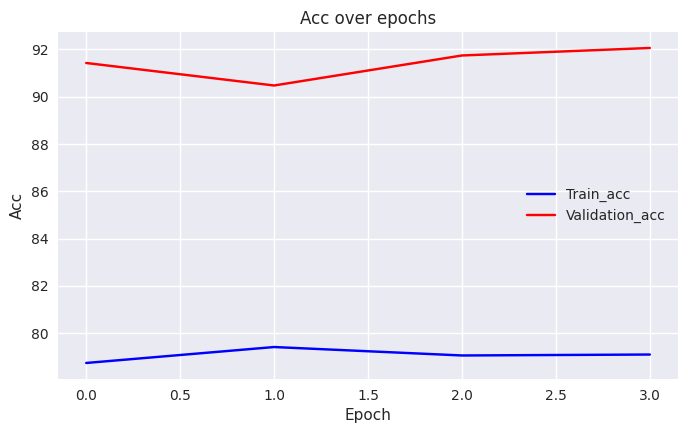

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, dataset['humidity']['train_loader'], dataset['humidity']['val_loader'], 4, device) # 2, 2

In [ ]:
save_checkpoint(model, optimizer, epoch=40, filename="checkpoint5.pth")
!cp '/content/checkpoint5.pth' '/content/drive/MyDrive/Internship/AHS/checkpoint5.pth'

In [ ]:
model, _ = load_checkpoint(model, filename="/content/drive/MyDrive/Internship/AHS/model/checkpoint5.pth")

In [ ]:
# test luôn sau khi train
evaluate(model, dataset) #

wound head: 83.40%
humidity head: 94.94%
redness head: 94.59%
scratch head: 93.71%
-------------------------
Final accuracy: 91.66%


In [ ]:
# save model và load lên
evaluate(model, dataset)

wound head: 85.33%
humidity head: 94.62%
redness head: 93.92%
scratch head: 92.31%
-------------------------
Final accuracy: 91.54%


In [ ]:
model2_ = {}
for name, param in model.named_parameters():
    model2_[name] = param.data

In [ ]:
model2_['scratch_head.0.bias']

tensor([-0.0150, -0.0052, -0.0273,  0.0263,  0.0039, -0.0406, -0.0066,  0.0385,
        -0.0115,  0.0163, -0.0093,  0.0052,  0.0006,  0.0069, -0.0220,  0.0200,
        -0.0140,  0.0359, -0.0345, -0.0309, -0.0057,  0.0468,  0.0317, -0.0193,
        -0.0144, -0.0383,  0.0291, -0.0352,  0.0116,  0.0171, -0.0253, -0.0076,
         0.0297,  0.0058, -0.0189, -0.0109, -0.0267, -0.0297,  0.0367, -0.0219,
         0.0133, -0.0421,  0.0208,  0.0264,  0.0328, -0.0174, -0.0089, -0.0286,
         0.0067, -0.0159,  0.0255, -0.0317,  0.0354,  0.0303, -0.0214, -0.0273,
         0.0119, -0.0032,  0.0231, -0.0378,  0.0227, -0.0389,  0.0426, -0.0149],
       device='cuda:0')

In [ ]:
for name in model1_.keys():
  if torch.all(torch.abs(model1_[name] - model2_[name]) > 1e-5):
    print(f"Parameter '{name}' has changed significantly.")

# **Problem**

In [ ]:
model2, _ = load_checkpoint(model, filename="/content/drive/MyDrive/Internship/AHS/model/checkpoint4.pth")

evaluate(model2, dataset)

wound head: 91.12%
humidity head: 92.09%
redness head: 91.89%
scratch head: 88.11%
-------------------------
Final accuracy: 90.80%


In [ ]:
sum(p.numel() for p in model2.parameters() if p.requires_grad)

33027

In [ ]:
for param in model.parameters(): # đóng băng toàn bộ model
    param.requires_grad_(False)

sum(p.numel() for p in model.parameters() if p.requires_grad)

0

In [ ]:
for param in model.humidity_head.parameters(): # Mở băng 1 head humidity
    param.requires_grad_(True)

sum(p.numel() for p in model.parameters() if p.requires_grad)

33027

Epochs: 0, Train_loss: 0.5552728645503521, Valid_loss: 0.2521729551255703, Train_accuracy: 78.22292740975804, Valid_accuracy: 92.38095238095238


<ipython-input-44-9d8ca1ce1d69>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


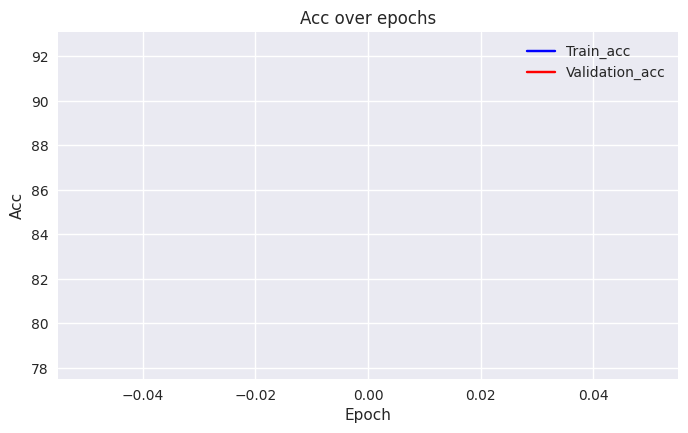

In [ ]:
model.mode = 'humidity'
optimizer = torch.optim.Adam(model.humidity_head.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, loss_function, optimizer, dataset['humidity']['train_loader'], dataset['humidity']['val_loader'], 1, device)